# **KALP ATIŞI SESİ SINIFLANDIRMA**


●Adım - 1: Öncelikle set_a ve set_b dosyarının içinde bulunan seslerin özniteliklerini(Mel-Frekans Kepstral Katsayıları, Zero Crossing Rate, Spectral Centroid, Spectral Rolloff, Chroma Frekansı) çıkaracağız.

●Adım - 2:Öznitelikleri ve sesin sınıfını görsel açıdan daha güzel görüntülemek ve rahat işlem yapmak için DataFrame’e çevireceğiz.

●Adım - 3:Oluşturduğumuz DataFrame’i Train ve Test olmak üzere ayırıp Scikit-Learn kütüphanesinde bulunan SVM, Random Forest ve Multi-layer Perceptron modellerini kullanarak çalışmamızı gerçekleştireceğiz.


# **Veri Kümesi Hakkında Ön Bilgi**

Kaggle’da bulunan Ed King tarafından yüklenmiş Heartbeat Sounds veri kümesini kullanacağız. 

**Veri kümesi içeriği;**
* **set_a.csv** — iPhone uygulaması ile ölçülmüş halktan elde edilmiş kalp atışları için etiketler ve metadatalar.
* **set_b.csv** — Dijital stetoskop ile hastanelerde yapılan klinik bir çalışmadan elde edilmiş kalp atışları için etiketler ve metadatalar.
* **set_a/set_b** — Uzunlukları 1 ile 30 saniye arası olan kalp atış seslerinin bulunduğu dosyalar.
* Veri kümemizdeki kalp atış seslerinin etiketleri artifact(yapay), murmur(hırıltılı), normal sınıflarından oluşuyor

#**1- Jupyter notebook sayfamız ile Google Drive arasındaki bağlantının yapılması için aşağıdaki kodu kullanıyoruz.**



In [1]:
#Notebook ile Drive arasındaki bağlantıyı sağlayalım
#Erişimi uzun olan drive dizini için kısa bir yol tanıma yapıyoruz
# "/content/gdrive/My\ Drive/" olan dizine /mydrive diyerek ulaşabiliriz.
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive


/
Mounted at /content/gdrive


In [2]:
%cd /mydrive/MAKINE_OGRENMESI2021/KALP

/content/gdrive/My Drive/MAKINE_OGRENMESI2021/KALP


In [3]:
!ls

 cat_1.wav			   set_a.csv
 Kalp_Sesi_Siniflandirma.ipynb	   set_a_timing.csv
'Kasabian - The Green Fairy.mp3'   set_b
 Ses_Oznitelik_Cikarimi.ipynb	   set_b.csv
 set_a


#**2- Gerekli Kütüphaneler ve Bazı Ayarlar.**

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import os,fnmatch

In [6]:
x,sr=librosa.load("set_a/normal__201105151450.wav",duration=5)
ipd.Audio(x,rate=sr)

In [7]:
#Ses dosyalarımız iki dosya içinde ayrı ayrı bulunduğu için liste içinde iki uzantı belirliyoruz ki döngü içinde sırasıyla kullanabilelim.
sound_folders=["set_a/","set_b/"]

In [8]:
# DataFrame sutunlarını belirleyelim.
sutunlar=["mfkk"+str(i) for i in range(20)]
for isim in ["zero","centroid","rolloff","chroma","class","dosya"]:
    sutunlar.append(isim)


In [9]:
#Aynı zamanda okuyacağımız sesler normal__201106221418.wav, artifact__201106221418.wav şeklinde isimlendirildikleri 
#için onları listelemek için de fnmatch kütüphanesinden yararlanacağız. Bu kütüphanenin filter() fonksiyonu bize dosyaları 
#düzenli bir şekilde okumamıza yardımcı olacak. Bu doğrultuda bir liste tanımlıyoruz.
#Örneğin normal* yazarak sadece normal ile başlayan dosya isimlerini çekebiliyoruz.
classes_liste=["normal*.wav","artifact*.wav","murmur*.wav"]

#**3- Özniteliklerin Çıkarılması.**

In [10]:
#Öznitelikleri çıkartıp DataFrame yapıyoruz
#fnmatch.filter ile dosyaları normal,artifact ve murmur olarak ayırıp sırasıyla listeliyoruz.

#Öznitelik çıkarımında birden fazla değer döndürdükleri için değerlerin ortalamalarını 
#alıp listemize ekliyoruz ve son olarak oluşturduğumuz bu listeyi DataFrame’e çevirip dönderiyoruz.
def ses_df(sound_folders,sutunlar,classes_list):
    liste=[]
    adim=0
    for folder in sound_folders:
        for classes in classes_list:          
            dosyalar=fnmatch.filter(os.listdir(folder),classes)
            label=classes.split("*")[0]
            for dosya in dosyalar:
                x,sr=librosa.load(folder+dosya,duration=5,res_type='kaiser_fast')
                #Mel frekans ölçeği, insan kulağının ses frekanslarındaki değişimi algılayışını gösteren bir ölçektir.
                liste.append([np.mean(x) for x in librosa.feature.mfcc(x,sr=sr)])
                #Toplam sıfır geçişi sayısı
                liste[adim].append(sum(librosa.zero_crossings(x))) 
                #Spektrumun kütle merkezinin nerede olduğunu gösterir.
                liste[adim].append(np.mean(librosa.feature.spectral_centroid(x)))
                #Sinyal şeklinin ölçüsü. Toplam spektral enerjisinin belli bir yüzdesini temsil eder.
                liste[adim].append(np.mean(librosa.feature.spectral_rolloff(x,sr=sr))) 
                #Spektrum müzikal oktavının 12 farklı yarı tonunu(chroma) temsil eden 12 parçanın belirtildiği ses için güçlü bir sunumudur.
                liste[adim].append(np.mean(librosa.feature.chroma_stft(x,sr=sr))) 
                liste[adim].append(label)
                liste[adim].append(dosya)
                adim+=1
    return pd.DataFrame(liste,columns=sutunlar)

In [11]:
sound_df=ses_df(sound_folders,sutunlar,classes_liste)
print(sound_df.shape)


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


(520, 26)


In [12]:
sound_df.head(10)

,mfkk0,mfkk1,mfkk2,mfkk3,mfkk4,mfkk5,mfkk6,mfkk7,mfkk8,mfkk9,...,mfkk16,mfkk17,mfkk18,mfkk19,zero,centroid,rolloff,chroma,class,dosya
0,-378.424774,116.696037,10.020765,18.323318,-1.762711,19.610312,0.973412,13.022606,-2.936234,17.787540,...,-12.099786,6.817950,-10.606353,8.801967,12403,2028.004601,5074.807739,0.636798,normal,normal__201102081152.wav
1,-563.907166,90.589951,0.516579,36.550186,5.384298,19.618626,1.978443,10.901742,-1.017188,5.758443,...,-6.578768,-3.621241,-5.281376,-3.913382,24628,2138.362099,4407.976278,0.696275,normal,normal__201104141251.wav
2,-561.614685,125.090157,23.035841,46.860672,15.440229,24.037390,4.017902,13.143376,-0.382773,6.116522,...,-5.050419,-2.607752,-4.751230,-3.442836,15928,1219.108148,2652.870687,0.623374,normal,normal__201102260502.wav
3,-341.600189,132.326324,-9.790151,19.992960,1.088059,28.099045,-4.117998,13.029923,-3.490481,15.133762,...,-2.265344,7.819179,-1.966817,2.172435,7731,1524.145749,3215.724691,0.637544,normal,normal__201102081321.wav
4,-491.902893,81.306252,-16.221800,24.758532,-10.702008,8.682656,-14.246324,3.572500,-13.872850,1.780240,...,-7.543078,-0.703531,-7.068611,-0.847794,23673,2659.210363,5513.995361,0.650562,normal,normal__201102270940.wav
5,-502.964203,75.497955,-0.143360,33.215046,1.885210,22.739941,-2.213355,15.641166,-5.976431,11.043531,...,-10.617104,-0.277429,-9.764259,-1.513115,23254,2590.061313,5494.007365,0.671843,normal,normal__201101070538.wav
6,-368.751740,90.998878,9.308592,44.516403,21.893858,27.270531,17.585390,19.014967,14.292042,20.767385,...,5.609330,6.301880,4.415701,3.487514,1506,916.416581,2174.803670,0.750161,normal,normal__201101151127.wav
7,-349.448425,169.767609,1.322672,6.548392,-5.808695,14.768840,-6.158533,7.391013,0.157573,5.180012,...,-3.739344,-8.650079,-14.775916,-7.841266,5910,1025.280520,1645.694987,0.599109,normal,normal__201105021804.wav
8,-374.499664,155.140335,17.615543,10.294283,15.977501,17.668228,11.507292,2.872385,0.928565,-1.417484,...,-3.710570,-3.660253,-2.877007,-2.551021,5338,940.794225,1738.058472,0.615981,normal,normal__201103140822.wav
9,-589.485046,95.902672,4.779768,25.718691,0.653998,14.962826,2.491838,9.250321,-0.675481,1.673499,...,-5.205617,-4.170212,-3.702754,-2.900511,26481,2138.851078,4358.928426,0.679843,normal,normal__201103140132.wav


In [13]:
sound_df["class"].value_counts()

normal      351
murmur      129
artifact     40
Name: class, dtype: int64

In [14]:
X=sound_df.iloc[:,0:24]
y=sound_df["class"]

#**3- Eğitim ve Test Kümelerini Oluşturma.**

In [15]:
#Modellerimizi üç sınıfı tahmin etmesi için eğiteceğiz. LabelEncoder ile sınıfları modellerimizin bunları anlayacağı bir hale getiriyoruz.

from sklearn.preprocessing import LabelEncoder

le=LabelEncoder().fit(y)
y=le.transform(y)


In [16]:
#Train ve Test olmak üzere oluşturduğumuz öznitelik verisini bölüyoruz.
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=31)

print("X Train: ",len(X_train),"\n","X Test: ",len(X_test),sep="")

X Train: 390
X Test: 130


#**4- Random Forest Sınıflandırma.**

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(max_depth= 8,
 max_features= 5,
 min_samples_split=5,
 n_estimators=500).fit(X_train,y_train)

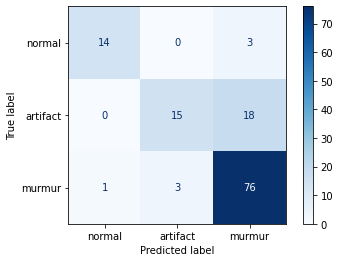

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred=forest.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal","artifact","murmur"])
disp.plot(cmap=plt.cm.Blues)
plt.show()




In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("Doğruluk:",accuracy_score(y_test, y_pred))
#print("Precision:",precision_score(y_test, y_pred))
#print("Recall:",recall_score(y_test, y_pred))
#print("F1 Score:",f1_score(y_test, y_pred,average='binary'))

Doğruluk: 0.8076923076923077


#**5- Multi-layer Perceptron sınıflandırma.**

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

mlp=MLPClassifier().fit(X_train_scaled,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


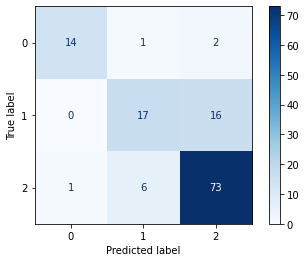

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred=mlp.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()




In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("Doğruluk:",accuracy_score(y_test, y_pred))
#print("Precision:",precision_score(y_test, y_pred))
#print("Recall:",recall_score(y_test, y_pred))
#print("F1 Score:",f1_score(y_test, y_pred,average='binary'))

Doğruluk: 0.8


#**5- SVM sınıflandırma.**

In [25]:
from sklearn import svm

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)


#rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train_scaled, y_train)
#poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train_scaled, y_train)
linear = svm.SVC(kernel='linear', degree=3, C=1).fit(X_train_scaled, y_train)

#poly_pred = poly.predict(X_test_scaled)
#rbf_pred = rbf.predict(X_test_scaled)
linear_pred = linear.predict(X_test_scaled)


linear_accuracy = accuracy_score(y_test, linear_pred)
linear_f1 = f1_score(y_test, linear_pred, average='weighted')
print('Accuracy (Linear Kernel): ', "%.2f" % (linear_accuracy*100))
print('F1 (Linear Kernel): ', "%.2f" % (linear_f1*100))

#poly_accuracy = accuracy_score(y_test, poly_pred)
#poly_f1 = f1_score(y_test, poly_pred, average='weighted')
#print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
#print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

#rbf_accuracy = accuracy_score(y_test, rbf_pred)
#rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
#print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
#print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (Linear Kernel):  84.62
F1 (Linear Kernel):  83.77


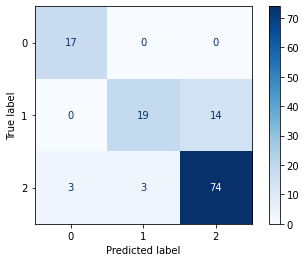

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, linear_pred, labels=linear.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linear.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
